## **EDA and Cleaning**

### **Import Library**

In [1]:
import pandas as pd
import numpy as np
import regex as re
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

np.random.seed(42)
%matplotlib inline

### **Male Fashion Advice Data Import**

#### **Import Data**

In [2]:
df = pd.read_csv('../data/df.csv')

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()

,subreddit,year,text
0,1,2019,how to find the best offers and deals on lapda...
1,1,2019,columbia fleece various colors and sizes shipp...
2,1,2019,pacsun vans old skool sizes free shipping
3,1,2019,massive toadampco sale some items off noooo id...
4,1,2018,chup socks for with code more


In [5]:
df.isnull().sum()

subreddit     0
year          0
text         50
dtype: int64

In [6]:
df.dropna(axis=0, inplace=True)

### **Word Frequency**

We want to see if there any obvious differences in word choice between the `Class 1` and `Class 0`.

#### Tokenize

We will instantiate tokenizer and search through words using our `r'\w+'` as our regular expression. Then we will tokenize our text column and create a new tokenized text column.

In [7]:
tokenizer = RegexpTokenizer(r'\w+')

In [8]:
df['tokenized'] = df['text'].map(lambda x: tokenizer.tokenize(x))

In [9]:
df['tokenized'] = df['tokenized'].map(lambda x: 1 if len(x) == 0 else x)

In [10]:
df = df[df['tokenized'] != 1]

In [11]:
df.reset_index(drop=True, inplace=True)

#### Lemmatize

We will convert words to their base forms so as to keep the count consistency when performing countvectorizer().

Instantiate lemmatizer

In [12]:
lemmatizer = WordNetLemmatizer()

We lemmatize the words in clean_text and concatenate them into one string.

In [13]:
df['lemmatized'] = df['tokenized'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [14]:
df = df[df['lemmatized'] != '']

In [15]:
df.head()

,subreddit,year,text,tokenized,lemmatized
0,1,2019,how to find the best offers and deals on lapda...,"[how, to, find, the, best, offers, and, deals,...","[how, to, find, the, best, offer, and, deal, o..."
1,1,2019,columbia fleece various colors and sizes shipp...,"[columbia, fleece, various, colors, and, sizes...","[columbia, fleece, various, color, and, size, ..."
2,1,2019,pacsun vans old skool sizes free shipping,"[pacsun, vans, old, skool, sizes, free, shipping]","[pacsun, van, old, skool, size, free, shipping]"
3,1,2019,massive toadampco sale some items off noooo id...,"[massive, toadampco, sale, some, items, off, n...","[massive, toadampco, sale, some, item, off, no..."
4,1,2018,chup socks for with code more,"[chup, socks, for, with, code, more]","[chup, sock, for, with, code, more]"


#### Stopwords

We will remove English stop words that will only contribute noise to our model rather than signal.

In [16]:
def remove_stop_words(df, col):
    clean_text = []
    set_stop_words = set([word for word in stop_words.ENGLISH_STOP_WORDS if word not in ['off']])
    more_stop_words = set(['ll', 'wa', 've', 'ha', 'look', 'like', 'just', 
                           'know', 'really', 'don', 'use', 'make', 'looking', 
                           'good', 'black', 'men',
                           ])
    for i in range(len(df)):
        stopless_words = [word for word in df[col][i] if not word in set_stop_words]
        meaningful_words = [word for word in stopless_words if not word in more_stop_words]
        clean_text.append(meaningful_words)
    return clean_text

The remaining words will be saved in the column clean_text.

In [17]:
df['clean_text'] = remove_stop_words(df, 'lemmatized')

In [18]:
df['clean_text'] = df['clean_text'].map(lambda x: ' '.join([word for word in x]))

In [19]:
df = df[df['clean_text'] != '']

In [20]:
df.head()

,subreddit,year,text,tokenized,lemmatized,clean_text
0,1,2019,how to find the best offers and deals on lapda...,"[how, to, find, the, best, offers, and, deals,...","[how, to, find, the, best, offer, and, deal, o...",best offer deal lapdance shoe amp lingerie dea...
1,1,2019,columbia fleece various colors and sizes shipp...,"[columbia, fleece, various, colors, and, sizes...","[columbia, fleece, various, color, and, size, ...",columbia fleece various color size shipping in...
2,1,2019,pacsun vans old skool sizes free shipping,"[pacsun, vans, old, skool, sizes, free, shipping]","[pacsun, van, old, skool, size, free, shipping]",pacsun van old skool size free shipping
3,1,2019,massive toadampco sale some items off noooo id...,"[massive, toadampco, sale, some, items, off, n...","[massive, toadampco, sale, some, item, off, no...",massive toadampco sale item off noooo idea err...
4,1,2018,chup socks for with code more,"[chup, socks, for, with, code, more]","[chup, sock, for, with, code, more]",chup sock code


#### CountVectorize

Using the lemmatized text, we will count the frequency of the terms from our posts.

Instantiate CountVectorizer():
- min_df=.03: drop terms with a document frequency of less than 3%. Terms that rarely occur will contribute noise.
- max_df=.95: drop terms with a document frequency of greater than 95%. Terms that occur in almost all documents will occur in both subreddits and will not contribute signal.

In [21]:
vect = CountVectorizer(min_df=.03, max_df=.95)

We create a dataframe of the vectorized frequency of the terms.

In [22]:
X = vect.fit_transform(df['clean_text'])
text = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

We will align each document to the subreddit it belongs to by setting the askmen column from our combined_df to the index of our text dataframe.

In [23]:
text.index = df['subreddit']

In [24]:
text.head()

,code,day,free,got,item,new,nike,off,pair,price,sale,shipping,shoe,size,sneaker,today
subreddit,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Visualization**

#### **Hot Male Fashion Advice Word Count**

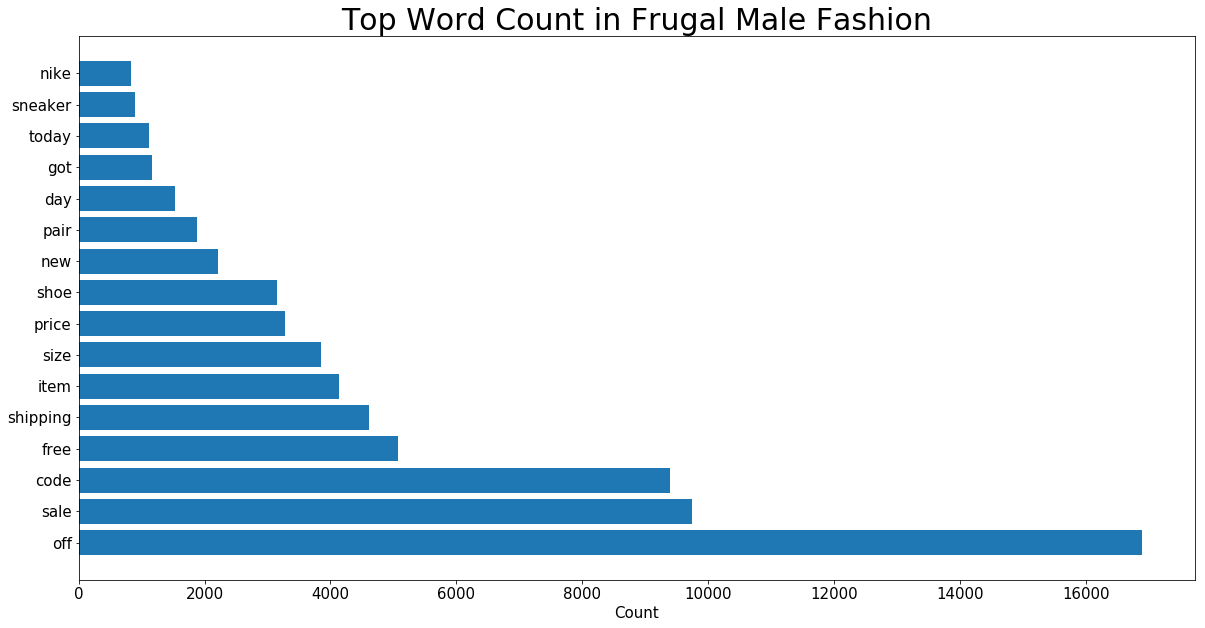

In [25]:
plt.figure(figsize=(20, 10))
plt.barh(y = text[text.index == 1].sum().sort_values(ascending=False).head(20).index,
         width = text[text.index == 1].sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count in Frugal Male Fashion', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Most of the top 20 words are related to item(s) being on sale: `off`, `sale`, `code`, `free`, `item`. Terms such as: `shipping`, `size`, `price`  indicates the saving money on those attributes. `store` indicates location of particular sale. `day` indicates time of event of sales.

#### **Old Male Fashion Advice Word Count**

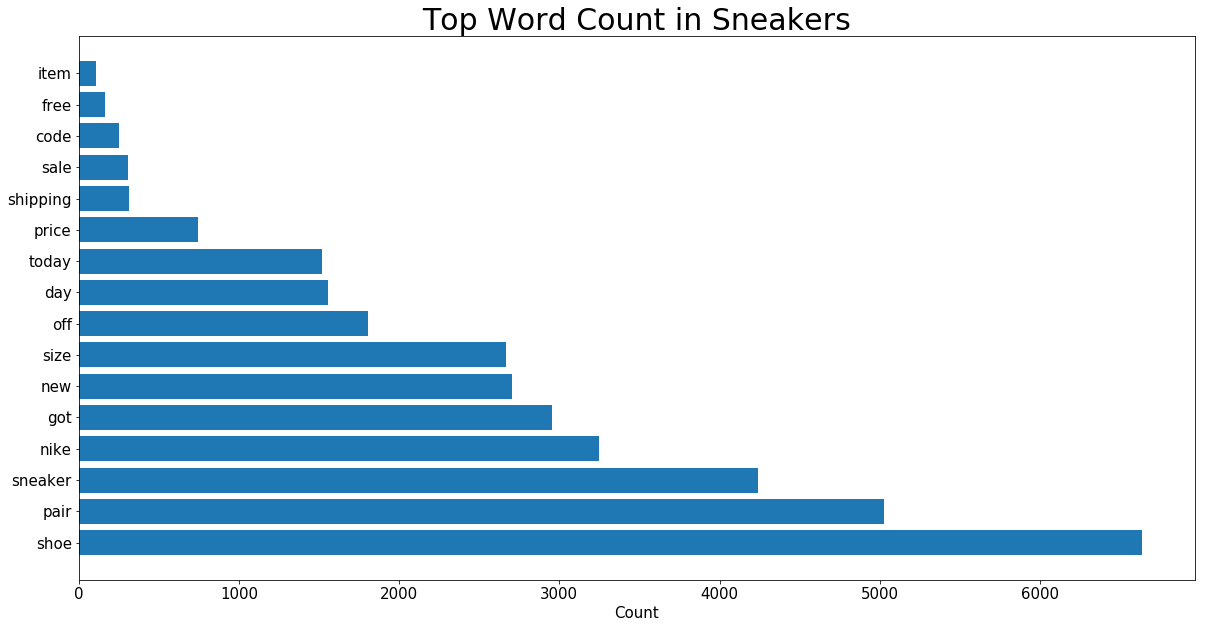

In [26]:
plt.figure(figsize=(20, 10))
plt.barh(y = text[text.index == 0].sum().sort_values(ascending=False).head(20).index,
         width = text[text.index == 0].sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count in Sneakers', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Most of the top 20 words are related to shoes: `shoe`, `pair`, `sneaker`, `size`. `nike` indicate the specific brand(s) of sneakers. `off` indicates user wear item(s) on their non-working schedule. Other terms such as `got`, `new`, `today`, `day` indicate recent acquistion of item(s) and user is displaying item(s).

### **Analysis**

There most frequent words found in both subreddits include:
- shoe
- size
- off
- new
- price
- day

These words indicate that users in both subreddits share information about shoes.

- `sale`, `code`, `free`, `shipping` occur the most frequently in `r/frugalmalefashion` but rarely in `r/sneakers` as there would be more sales related terms in a subreddit dedicated to posting sales.
- `shoe`, `pair`, `sneaker`, `nike` occur the most frequently in `r/sneakers` but not as frequently in `r/frugalmalefashion` as there would be more similar acquisition related terms in a subreddit dedicated to displaying sneakers.

### **Save out as csv**

In [27]:
df.to_csv('../data/clean_df.csv')

In [28]:
text.to_csv('../data/vect_df.csv')